# Evaluate the AdaBoost model
We will evaluate the performance of the AdaBoost model with optimized hyperparameters, all four metadata features (virus avidity, antiserum potency, and passage category (egg or cell) of virus isolates and antisera) and best-performing amino acid mutation matrix 'GIAG010101' over 18 test seasons from 2001NH to 2009SH.

## Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from ast import literal_eval
import random
import gc

# self defined functions and models
import utilities
import model_utilities

# for encoding of metadata information
from sklearn.preprocessing import OneHotEncoder

# for parallel computation
from functools import partial
from joblib import Parallel, delayed

# for reproduciblility, fix the randomly generated numbers
SEED = 100
random.seed(SEED)
np.random.seed(SEED)

## Variables

In [2]:
mut_mat       = 'GIAG010101'   # mutation matrix
Test_Seasons = [str(year)+s for year in range (2001, 2010) for s in ['NH', 'SH']]   # seasons from 2001NH to 2009SH

HA1_features  = [f"HA1_{x}" for x in range(1,326+1)]
meta_features = [
                 'virusName',   # virus avidity
                 'serumName',   # antiserum potency
                 #'virusPassCat',   # virus passage category
                 #'serumPassCat'   # serum passage category
                 ]   # metadata features

metadata   = 'a+p'   # label to record which metadata is being used
model_name = 'AdaBoost'   # the type of model to be used

## Paths and filenames

In [3]:
# paths
path_data   = "../data/"   # path of data
path_result = "../results/SuppFig9_H1N1/"   # results will be saved in this directory
Path(path_result).mkdir(parents=True, exist_ok=True)   # make directory if it does not exist already

# filenames
data_fn    = path_data + f"H1N1_NHTs_{mut_mat}.csv"   # input data
results_fn = path_result + "SuppFig9b_performance_testScores.csv"   # to save performance scores for test dataset

# filenames for figures are mentioned within the codes for figures

## Read data
- Genetic difference (seq_diff) encoded as per the mutation matrix
- Converter is used to load the genetic difference saved as a list of floats

In [4]:
data = pd.read_csv(data_fn, converters={'seq_diff': literal_eval})

## Function to compute performance of model for a given season
- Split the data into training and validation datasets
- Prepare encoded inputs (genetic difference and metadata features)
- Train and validate the model
- Compute predictive performance

> **Parameters**
> - season (str): identifier for the Northern of Southern Hemisphere season such as "2015NH"

> **Returns**
> - (numpy array): actual NHTs for the given season
> - (numpy array): predicted NHTs for the given season

In [5]:
def train_test_season(season):
    '''
    Train Test Split
        - based on seasonal framework
        - Train: past virus isolates paired with past sera
        - Test: circulating virus isolates paired with past sera
    '''
    ind_train, ind_test = utilities.seasonal_trainTestSplit(data[['virusDate', 'serumDate']], season)
    
    # training dataset
    data_train = data.iloc[ind_train].copy()
    data_train.reset_index(drop=True, inplace=True)
    
    # test dataset
    data_test = data.iloc[ind_test].copy()
    data_test.reset_index(drop=True, inplace=True)


    '''
    Input features (genetic difference)
    '''
    # training dataset
    X_train = pd.DataFrame(data_train.seq_diff.to_list(),
                           index=data_train.index,
                           columns=HA1_features)
    X_train.fillna(0, inplace=True)   # replace nan with 0
    
    # test dataset
    X_test = pd.DataFrame(data_test.seq_diff.to_list(),
                          index=data_test.index,
                          columns=HA1_features)
    X_test.fillna(0, inplace=True)   # replace nan with 0
    
    
    '''
    Input features (metadata features)
    '''
    X_train_meta = data_train[meta_features].fillna('None').astype('str')
    X_test_meta  = data_test[meta_features].fillna('None').astype('str')
    
    
    # one hot encoding
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_train_meta = ohe.fit_transform(X_train_meta).toarray()
    X_test_meta  = ohe.transform(X_test_meta).toarray()
      
    X_train = np.hstack((X_train.values, X_train_meta))
    X_test  = np.hstack((X_test.values, X_test_meta))


    del X_train_meta, X_test_meta
    gc.collect()
        
    
    '''
    Training and testing
    '''
    model = getattr(model_utilities, f"model_{model_name}")
    results = model(X_train,
                    data_train.nht.values,
                    X_test = X_test)
    
    
    '''
    Test Scores
    '''
    cols       = ['mut_mat', 'model', 'metadata', 'season']
    col_values = [mut_mat, model_name, metadata, season]
    utilities.compute_scores(data_test.nht.values, results['pred_test'], results_fn, col=cols, col_val=col_values)
    
    
    return season, data_test.nht.values, results['pred_test']

## Performance of the model
- For each test season
    - Split the data into training and test datasets
    - Prepare encoded inputs (genetic difference and metadata features)
    - Train and evaluate the model
    - Compute predictive performance
    - Save the predictions
- Compute average predictive performance

In [6]:
# train test for each test season in parallel
result = Parallel(n_jobs=-1, verbose=1)(delayed(train_test_season)(test_season) for test_season in Test_Seasons)

# get results
seasons, actual_all, predict_all = zip(*result)

'''
Micro-average over seasons
'''
actual  = np.concatenate(actual_all)
predict = np.concatenate(predict_all)

# Test scores
cols       = ['mut_mat', 'model', 'metadata', 'season']
col_values = [mut_mat, model_name, metadata, 'Average']
utilities.compute_scores(actual, predict, results_fn, col=cols, col_val=col_values)

print("Training and testing completed")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:   56.6s remaining:   16.1s


Training and testing completed


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.5min finished


## Imports and configuration for plotting

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context(rc={'axes.labelsize':9,
                    'xtick.labelsize':8,
                    'ytick.labelsize':8,
                    'legend.fontsize':8,
                    'legend.title_fontsize':8})

## Read test scores and prepare data for plots

In [8]:
metrics = ['MAE', 'AUROC']

scores = pd.read_csv(results_fn)
scores = scores[['season']+metrics]

'''
for heatmap change to matrix form
'''
# set season as index
df = scores.set_index('season')

# transpose index and columns
df = df.transpose()

## Plot MAE per season

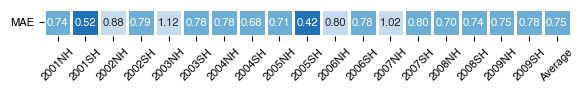

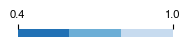

In [11]:
fig, ax = plt.subplots(figsize=(6.8,0.35))
fig_cbar, ax_cbar = plt.subplots(figsize=(2,0.1))   # separate figure for colorbar

tmp = sns.heatmap(df[df.index == 'MAE'],
                  annot=True, annot_kws={'size':8}, fmt='.2f',
                  vmin=0.4,
                  vmax=1.0,
                  cmap=sns.color_palette('Blues_r', 3),
                  cbar_ax=ax_cbar,
                  cbar_kws={'shrink':0.85, 'orientation':'horizontal'},
                  linewidths=1,
                  # square=True,
                  ax=ax)

# configurations for figure
tmp.set_xticklabels(tmp.get_xticklabels(), rotation=45)
cbar = tmp.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_xticks([cbar.ax.get_xticks()[0], cbar.ax.get_xticks()[-1]])
cbar.ax.xaxis.set_ticks_position('top')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
ax.set_xlabel("")
ax.set_ylabel("")

# save figure
fig_fn = path_result + "SuppFig9b_testScores_MAE_heatmap.svg"
fig.savefig(fig_fn, format='svg', bbox_inches='tight')

# save figure for colorbar
fig_cbar_fn = path_result+"SuppFig9b_testScores_MAE_heatmap_colorbar.svg"
fig_cbar.savefig(fig_cbar_fn, format='svg', bbox_inches='tight')

## Plot AUROC per season

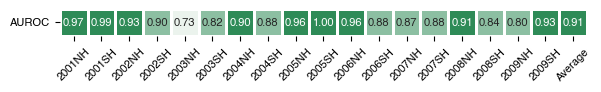

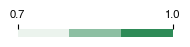

In [14]:
fig, ax = plt.subplots(figsize=(6.8,0.35))
fig_cbar, ax_cbar = plt.subplots(figsize=(2,0.1))

tmp = sns.heatmap(df[df.index == 'AUROC'],
                  annot=True, annot_kws={'size':8}, fmt='.2f',
                  vmin=0.7,
                  vmax=1,
                  cmap=sns.light_palette('seagreen', 3),
                  cbar_ax=ax_cbar,
                  cbar_kws={'shrink':0.85, 'orientation':'horizontal'},
                  linewidths=1,
                  # square=True,
                  ax=ax)

# configurations for figure
tmp.set_xticklabels(tmp.get_xticklabels(), rotation=45)
cbar = tmp.collections[0].colorbar
cbar.ax.tick_params(labelsize=8) 
cbar.ax.set_xticks([cbar.ax.get_xticks()[0], cbar.ax.get_xticks()[-1]])
cbar.ax.xaxis.set_ticks_position('top')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
ax.set_xlabel('')
ax.set_ylabel('')

# save figure
fig_fn = path_result + "SuppFig9b_testScores_AUROC.svg"
fig.savefig(fig_fn, format='svg', bbox_inches='tight')

# save figure for colorbar
fig_cbar_fn = path_result + "SuppFig9b_testScores_AUROC_colorbar.svg"
fig_cbar.savefig(fig_cbar_fn, format='svg', bbox_inches='tight')